In [842]:
# import torch
# import torchvision
# from torch import nn
# from torch.utils.data import DataLoader
# from matplotlib import pyplot as plt
# from torchvision import datasets
# from torchvision import transforms
# import numpy
# import cv2

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Using device: {device}')


In [843]:
# # dataset = torchvision.datasets.MNIST(root="../data", train=True, download=True, transform=torchvision.transforms.ToTensor())

# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
#     ])
# dataset = datasets.ImageFolder(root="SkinData/data", transform=transform)
# # data_loader = torch.utils.data.DataLoader(dataset)
# # おっと、4が混ざりました。1か8か、あるいは4です。
# # 好きな数字に変えても良いでしょう。
# target_values = [0,1]

# target_images = []
# for data in dataset:
#     if data[1] in target_values:
#         target_images.append(data)

# train_dataloader = DataLoader(target_images, batch_size=8, shuffle=True)

In [844]:
# def corrupt(x, amount):
#   """
#     x : 入力する画像(複数), x.shape = torch.Size([batch_size, 1, 28, 28])
#     amount : 各画像にどれだけノイズを入れるかの比率を入れたndarray, 0->そのまま, 1->完全にノイズ
#   """
#   noise = torch.rand_like(x)
#   amount = amount.view(-1, 1, 1, 1) 
#   return x*(1-amount) + noise*amount 


In [845]:
# batch_size = 128
# train_dataloader = DataLoader(target_images, batch_size=batch_size, shuffle=True)

# max_epochs = 5

# net = BasicUNet()
# net.to(device)

# loss_func = nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) 

# history = []
# for epoch in range(max_epochs):
#     for x, y in train_dataloader:
#         x = x.to(device)
#         # どれくらいノイズを入れるかは乱数で決める
#         noise_amount = torch.rand(x.shape[0]).to(device)
#         noisy_x = corrupt(x, noise_amount)

#         pred = net(noisy_x)
#         loss = loss_func(pred, x)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         history.append(loss.item())

#     avg_loss = sum(history[-len(train_dataloader):])/len(train_dataloader)
#     print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# plt.plot(history)
# plt.ylim(0, 0.1)


In [846]:
# n_steps = 5
# x = torch.rand(8, 1, 28, 28).to(device)
# step_history = [x.detach().cpu()]
# pred_output_history = []

# for i in range(n_steps):
#     with torch.no_grad():
#         pred = net(x)
#     pred_output_history.append(pred.detach().cpu())

#     mix_factor = 1/(n_steps - i)
#     x = x*(1-mix_factor) + pred*mix_factor
#     step_history.append(x.detach().cpu())

# _, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
# axs[0,0].set_title('x (model input)')
# axs[0,1].set_title('model prediction')
# for i in range(n_steps):
#     axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
#     axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')


In [847]:
# n_steps = 40
# x = torch.rand(64, 1, 28, 28).to(device)

# for i in range(n_steps):
#   with torch.no_grad():
#     pred = net(x)
#   mix_factor = 1/(n_steps - i)
#   x = x*(1-mix_factor) + pred*mix_factor

# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

Epoch 100/100, Loss: 0.02583591453731066

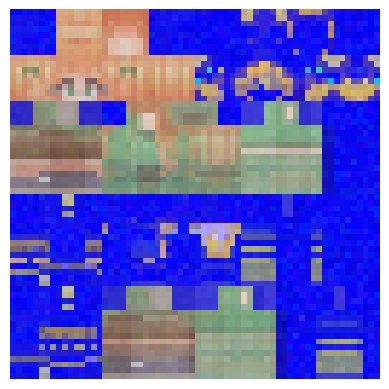

In [855]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root="SkinData/data", transform=transform)
dataloader = DataLoader(dataset)

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = 64 * 64 * 3  # 64x64のRGB画像
model = DiffusionModel(input_dim=input_dim, hidden_dim=200, output_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 100
for epoch in range(num_epochs):
    for data in dataloader:
        images, _ = data
        images = images.view(images.size(0), -1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
    print(f"\rEpoch {epoch+1}/{num_epochs}, Loss: {loss.item()}",end="")

generated_images = model(torch.randn(1, input_dim))
generated_images = generated_images.view(3, 64, 64).detach().numpy()

plt.imshow(np.transpose(generated_images, (1, 2, 0)))
plt.axis('off')
plt.show()


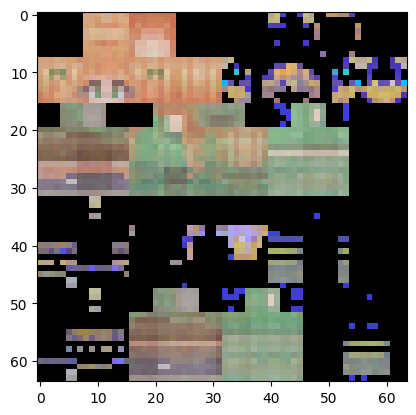

In [856]:
image_array_scaled = (np.transpose(generated_images, (1, 2, 0)) * 255).astype(np.uint8)
img = cv2.cvtColor(image_array_scaled, cv2.COLOR_RGB2BGRA)
h, w = img.shape[:2]
for i in range(h):
    for j in range(w):
        b, g, r, a = img[i, j]
        if int(b) >= 150 and int(g)+int(r) <= 120:
            img[i, j] = 0,0,0,0
        # elif (int(b) >= 100 and int(g)+int(r) <= 250) and (32<= j and i <= 15) or (32 <= i <= 47) or (j <= 15 and 48 <= i) or (46 <= j and 48 <= i):
        #     if b >= 80:
        #         img[i, j] = b-80,g,r,255-b//2
        #     else:
        #         img[i, j] = 0,g,r,255-b//2

dir_path = "Created_Skin/"
files = os.listdir(dir_path)
cv2.imwrite(f'{dir_path}ai_{len(files)+1}.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
plt.show()